In [1]:
import numpy as np
import pandas as pd
import numpy as np
import cvxpy as cvx

import matplotlib.pyplot as plt
import scipy.optimize as scopt
import seaborn as sns

# Ньютоновские и Квазиньютоновские методы

## Идея: квадратичная аппроксимация

$$
f(x + h) \approx f(x) + \langle f'(x), h \rangle + \frac{1}{2}h^{\top}f''(x)h \to \min_{h}
$$

Из необходимого условия минимума:

$$
f'(x) + f''(x) h = 0, \qquad h^* = -(f''(x))^{-1} f'(x)
$$

## Точно убываем с таким шагом?

###  Если гессиана положительно определен, то. да

$$
\langle f'(x), h^* \rangle = -(f')^{\top}(x) (f''(x))^{-1} f'(x) < 0 \Leftarrow f''(x) \succ 0
$$

## Классический метод Ньютона

$$
x_{k+1} = x_{k} - (f''(x))^{-1} f'(x)
$$

++ Квадратичная  сходимость около решения

-- Сходится не из любой точки



## Дэмпфированный (Затухающий) метод Ньютона

### Вводится шаг

$$
x_{k+1} = x_{k} - \alpha (f''(x))^{-1} f'(x)
$$

Подбор шага с единички!!!



## Рубрика Эксперименты

Будем минимизировать функция Химмельблау
$$
f = (x^2+y-11)^2 + (x+y^2-7)^2
$$

In [54]:
def f(x):
    x, y= x[0], x[1]
    return (x*x+y-11)**2 + (x+y*y-7)**2

def grad_f(x):
    x, y= x[0], x[1]
    return np.array([4* x * (x*x+y-11) + 2 *( x+y*y-7),  4 * y *(x+y*y-7 ) + 2*(x*x+y-11) ])

def hess_f(x):
    x, y= x[0], x[1]
    return np.array([[4*  (x*x+y-11) + 8*x*x +2, 4*x+4*y],  [4*x+4*y,4* (x+y*y-7) + 8*y*y +2 ] ])

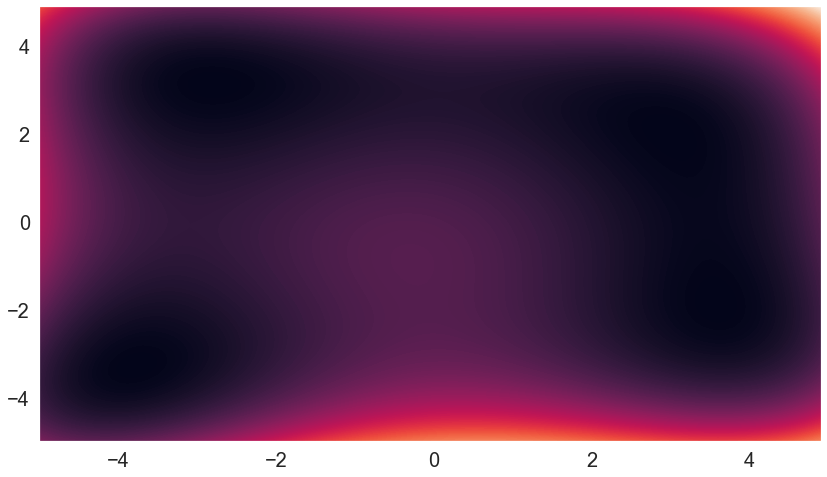

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
np.random.seed(23)
n=100


n_points = 1000

X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
x, y = np.meshgrid(X, Y)

f_x = f((x,y))



plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# plt.legend(loc="best", fontsize=20)
plt.contourf(x, y, f_x, levels =230)

У химмельблау четыре равнозначных локальных минимума
$$
{\displaystyle f(3,2)=0},\\
{\displaystyle f(-2{,}805118...,3{,}131312...)=0},\\
{\displaystyle f(-3{,}779310...,-3{,}283186...)=0},\\
{\displaystyle f(3{,}584428...,-1{,}848126...)=0}.
$$

И локальный максимум

$$
{\displaystyle f({\displaystyle  -0{,}270845}, {\displaystyle  -0{,}923039})=181.617}
$$

In [5]:

import types
def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

#Callback и в  GD и в CG написан по убогому, поэтому этот костыль для рисования графика
def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)





In [205]:
def NewtonDescent(f, gradf, hess_f, x0, alpha=1., max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    
    iteration = 0
    conv_array = [x]

  
    while True:

      
        
        alpha = alpha
        gradient = gradf(x)
        inv_hess = np.linalg.pinv(hess_f(x))
        step = inv_hess @ gradient
        x = x - alpha * step
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [219]:
#GradientDescent честно скопированный с предыдущего семнара
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    
    iteration = 0
    conv_array = [x]

  
    while True:

      
        
        alpha = 0.01
        gradient = gradf(x)
        x = x - alpha * gradient
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


In [216]:
x0 = np.array([4., 4.])
res = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_gd, y_gd = get_x_y_from_callback(res['conv_array'], x0) 

In [137]:
x0 = np.array([4., 4.])
res = NewtonDescent(f, grad_f,hess_f , x0, rho=0.5, beta1=0.2)
x_nd, y_nd = get_x_y_from_callback(res['conv_array'], x0) 

In [153]:

x1 = np.array([-1., 0.])


In [154]:
res = GradientDescent(f, grad_f, x1)
x_gd1, y_gd1 = get_x_y_from_callback(res['conv_array'], x1) 

In [155]:
res = NewtonDescent(f, grad_f,hess_f , x1)
x_nd1, y_nd1 = get_x_y_from_callback(res['conv_array'], x1) 

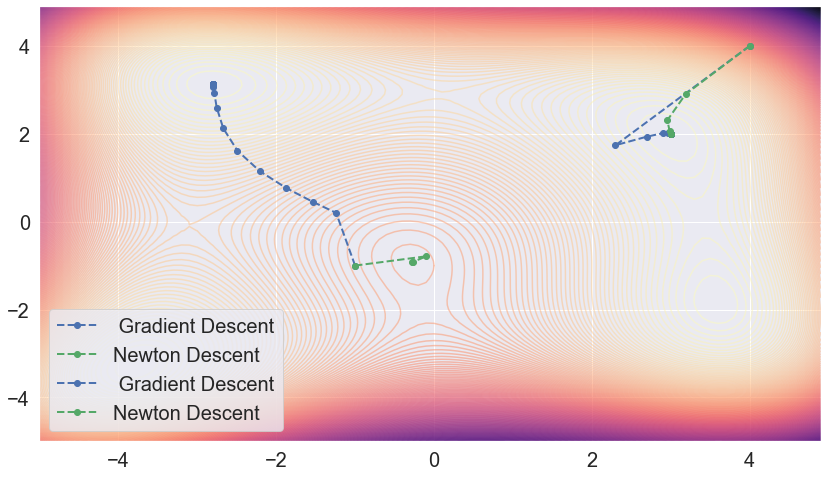

In [159]:
sns.set()

plt.figure(figsize = (14, 8))
plt.plot(x_gd, y_gd, '--bo',linewidth=2, label=' Gradient Descent')
plt.plot(x_nd, y_nd ,'--go', linewidth=2, label='Newton Descent')
plt.plot(x_gd1, y_gd1, '--bo',linewidth=2, label=' Gradient Descent')
plt.plot(x_nd1, y_nd1 ,'--go', linewidth=2, label='Newton Descent')
# plt.plot(x_na, y_na ,'--go', linewidth=2, label='NA Gradient Descent')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)
plt.contour(x, y, f_x,  levels =230, cmap = 'magma_r', alpha=0.5)

Из разных точек мы запустили Градиентный спуск и Метод Ньютона. Что произошло?


В Правом верхнем углу, Ньютон превзошел ГД в 11 раз

In [139]:
len(x_gd), len(x_nd)

(66, 6)

Во втором случае НЬютон сошелся к Максимуму. Почему?


In [157]:
f(res['conv_array'][-1])

181.61652152253532

## Изучим поведение методов на выпуклой функции


Функция 
$$
f (x) = -\sum\log(1-A^T x)-\sum\log(1-x^2 )
$$

In [9]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

### Получим точное решение через cvxpy

In [201]:
n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Nov 17 09:25:22 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 17 09:25:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 09:25:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 09:25:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 09:25:22 PM: Compiling problem (target solver=SCS).
(CVXPY) Nov 17 09:25:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Nov 17 09:25:23 PM: Finished problem compilation (took 2.281e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 17 09:25:23 PM: Invoking solver SCS  to obtain a solution.
----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 205200
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3200, constraints m = 6600
Cones:	soc vars: 3000, soc blks: 1000
	exp vars: 3600, dual exp vars: 0
Setup time: 1.71e-01s
------------------------------------------------------------------

In [220]:
res = GradientDescent(f, grad_f, x0)
res_newton = NewtonDescent(f, grad_f, hess_f , x0)

No handles with labels found to put in legend.


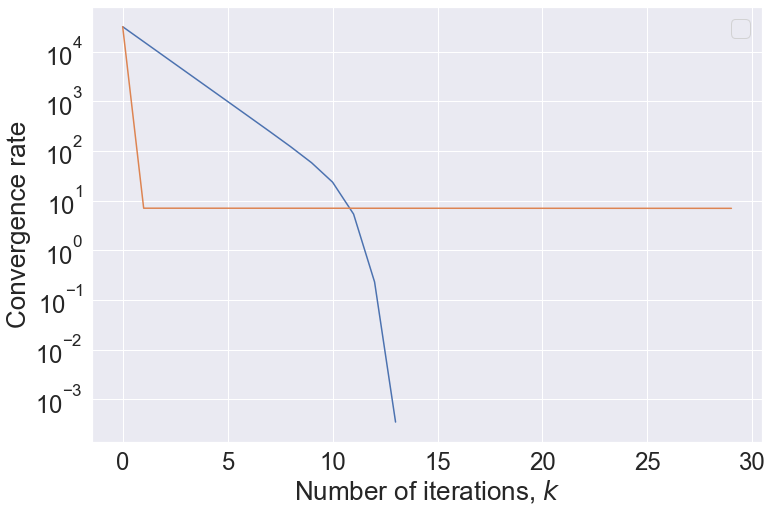

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=False)
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy(np.array([np.linalg.norm(grad_f(x)) for x in res_newton['conv_array']]))
# Gradient
plt.semilogy(np.array([np.linalg.norm(grad_f(x)) for x in res['conv_array'][:30]]))
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Convergence rate", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)

# Квазиньютоновские методы

Метод Ньютон вытекает из квадратичной аппроксимации 


$$
f(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}f''(y)(x-y)
$$

Идея квазиньютоновских методов в том, чтобы приблизить матрицу Гёссе или обратный Гессиан на каждой итерации


$$
f_q(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}{\color{blue}{B(y)}}(x-y),
$$



$$
x_{k+1} = x_k - \alpha_k {\color{blue} B^{-1}_k} f'(x_k) = x_k - \alpha_k {\color{blue} H_k} f'(x_k)
$$

## Как искать $B_{k+1}$?

В точке $x_{k+1}$ имеем следующую аппрокисмацию:

$$
f_q(h) \approx f(x_{k+1}) + \langle f'(x_{k+1}), h \rangle + \frac{1}{2}h^{\top}B_{k+1}h
$$

Из определения, очевидно, что $B_{k+1} \in \mathbb{S}^n_{++}$.
Какие требования естественно наложить на $f_q(h)$?

### Правило двух градиентов

$$
f_q'(-\alpha_k h_k) = f'(x_k) \qquad f'_q(0) = f'(x_{k+1}),
$$

где первое условие даёт

$$
f'(x_{k+1}) - \alpha_k B_{k+1}h_k = f'(x_k),
$$

а второе выполняется автоматически.

Делаем замены

$$s_k = x_{k+1} - x_k$$ $$y_k = f'(x_{k+1}) - f'(x_k)$$

### Отсюда вытекает квазиньютоновское уравнение (Secant equation)

Из первого условия получаем

$$
B_{k+1}s_k = y_k,
$$



# Cнова Эксперименты!!

## Здесь и далее задача

Функция 
$$
f (x) = -\sum\log(1-A^T x)-\sum\log(1-x^2 )
$$

In [26]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
gradf = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

## Barzilai-Borwein method

### Идея метода


- Аппроксимация гессиана диагональной матрицей:

$$
\alpha_k f'(x_k) = \alpha_k I f'(x_k) = \left( \frac{1}{\alpha_k} I \right)^{-1} f'(x_k) \approx f''(x_k))^{-1} f'(x_k)
$$

### Тогда квазиньютоновское уравнение принимает вид

$$
\left( \frac{1}{\alpha_k} I \right)^{-1}  s_{k-1} =\alpha_k^{-1} s_{k-1} \approx y_{k-1}
$$

### Три способа найти $\alpha_k$

- Первый способ
    - Задача
    
    $$
    \min_{\beta} \|\beta s_{k-1} - y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{1}{\beta} = \frac{s^{\top}_{k-1} s_{k-1}}{s^{\top}_{k-1} y_{k-1}}
    $$
    
- Второй способ
    - Задача
    
    $$
    \min_{\alpha} \| s_{k-1} - \alpha y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{s^{\top}_{k-1} y_{k-1}}{y^{\top}_{k-1} y_{k-1}}
    $$

In [6]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    x_array = []
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)

        x_array.append(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    x_array.append(x_prev)
    return x_next, x_array

## Можно посмотреть на задачу по -другому 


\begin{align*}
& \min_B \| B_k - B_{k+1} \| \\
\text{s.t. } & B_{k+1} = B_{k+1}^{\top}\\
& B_{k+1}s_k = y_k
\end{align*}

## DFP (Davidon-Fletcher-Powell)

$$
B_{k+1} = (I - \rho_k y_k s^{\top}_k)B_k(I - \rho_k s_ky^{\top}_k) + \rho_k y_k y^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$,

или с помощью формулы Шермана-Морисона-Вудбери ${\displaystyle \left(A+uv^{\textsf {T}}\right)^{-1}=A^{-1}-{A^{-1}uv^{\textsf {T}}A^{-1} \over 1+v^{\textsf {T}}A^{-1}u}.}$





$$
B^{-1}_{k+1} = H_{k+1} = H_k - \dfrac{H_ky_k y_k^{\top}H_k}{y^{\top}_kH_ky_k} + \dfrac{s_ks^{\top}_k}{y^{\top}_ks_k}
$$



In [7]:
def dfp_method(f, gradf, x0, tol=1e-6, maxiter=100):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    H = np.eye(x_prev.shape[0])
    y =  - H @ gradf(x_prev)
    x_array = []
    while current_tol > tol and it < maxiter:
        #alpha backtracking
        ro=0.5 

        alpha0 = 1
        beta1=1e-3
        beta2=0.9
        alpha =  backtracking (x_prev, f, gradf, ro, alpha0, beta1, beta2)
        
        # s difference between coordinates
        s = alpha * y
        x_new = x_prev +  s
        
        #y ddifference between grads
        y = gradf(x_new) - gradf(x_prev)
        
        
        # H update        
        rho = 1. / y.dot(s)
        if it == 0:
            H = H / y.dot(y) / rho
        Hy = H @ y
        H = H -  (np.outer(Hy, Hy) / (y.dot(Hy))) + (np.outer(s, s) * rho)

        x_prev = x_new
        y =  -H @ gradf(x_prev)       
       
        
        
        x_array.append(x_prev)
        
        current_tol = np.linalg.norm(gradf(x_new))
      
        it+=1

    x_array.append(x_prev)
    return x_new, x_array

In [11]:
x, x_array= dfp_method(f, gradf, x0, tol=1e-6, maxiter=100)
xbb, xbb_array = bb_method(f, gradf, x0)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


## BFGS

\begin{align*}
& \min_H \| H_k - H_{k+1} \| \\
\text{s.t. } & H_{k+1} = H_{k+1}^{\top}\\
& H_{k+1}y_k = s_k
\end{align*}

Формула пересчёта для метода BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

In [34]:
def bfgs_method(f, gradf, x0, tol=1e-6, maxiter=100):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    H = np.eye(x_prev.shape[0])
    y =  - H @ gradf(x_prev)
    x_array = []
    while current_tol > tol and it < maxiter:
        #alpha backtracking
        ro=0.5 
        alpha0 = 1
        beta1=1e-3
        beta2=0.9
        alpha =  backtracking (x_prev, f, gradf, ro, alpha0, beta1, beta2)
        
        # s difference between coordinates
        s = alpha * y
        x_new = x_prev +  s
        
        #y ddifference between grads
        y = gradf(x_new) - gradf(x_prev)
        
        # H update
        rho = 1. / y.dot(s)
        if it == 0:
            H = H / y.dot(y) / rho
        Hy = H @ y
        H = H +   (np.outer(s, s) * rho) *(1 +  (y @ Hy) * rho) - (np.outer(Hy,s) + np.outer(s, Hy))* rho

        
        x_prev = x_new
        y =  -H @ gradf(x_prev)       
       
        
        
        x_array.append(x_prev)
        
        current_tol = np.linalg.norm(gradf(x_new))
        it+=1

    x_array.append(x_prev)
    return x_new, x_array

In [35]:
x_bfgs, x_array_bfgs = bfgs_method(f, gradf, x0, tol=1e-6, maxiter=100)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


## BFGS с ограниченной памятью (L-BFGS)

- В методе BFGS нужна не сама матрица $H$, а только функция умножения её на вектор 
- Поскольку требуется локальная оценка гессиана, старые значения векторов $s$ и $y$ могут портить текущую оценку

**Идея**

- Хранить $k \ll n$ последних векторов $s$ и $y$ - снижение требуемой памяти с $n^2$ до $kn$
- Выполнение умножения на вектор рекурсивно, без явного формирования матрицы $H$

Будем обновлять Рекунсивно $H_k$

$$
H_{k+1} = V_{k}^{T} H_{k} V_{k} + \rho_k s_k s_k^{T}
$$

$$
V_{k} = I  -\rho_k y_k s_k^{T}
$$

In [17]:
from collections import deque

In [28]:
def lbfgs_method(f, gradf, x0, hist_size=10, tol=1e-6, maxiter=100):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    H = np.eye(x_prev.shape[0])
    y =  - H @ gradf(x_prev)
    s_hist = deque(maxlen=hist_size)
    y_hist = deque(maxlen=hist_size)
    x_array = []
    while current_tol > tol and it < maxiter:
        #alpha backtracking
        ro=0.5 
        alpha0 = 1
        beta1=1e-3
        beta2=0.9
        alpha =  backtracking (x_prev, f, gradf, ro, alpha0, beta1, beta2)
        
        # s difference between coordinates
        s = alpha * y
        x_new = x_prev +  s
        
        #y ddifference between grads
        y = gradf(x_new) - gradf(x_prev)
        
        # update deques
        s_hist.append(s)
        y_hist.append(y)
        

      
        x_prev = x_new
        
        alpha = np.zeros(len(s_hist))
        rho = np.zeros(len(s_hist))
        q = gradf(x_prev)
        
        for i in range(len(s_hist) - 1, -1, -1):
            rho[i] = 1. / s_hist[i].dot(y_hist[i])
            alpha[i] = s_hist[i].dot(q) * rho[i]
            q = q - alpha[i] * y_hist[i]
        r = H @ q
        for i in range(len(s_hist)):
            beta = rho[i] * y_hist[i].dot(r)
            r = r + s_hist[i] * (alpha[i] - beta)

        
        y =  - r #H @ gradf(x_prev)  
       
       
        
        
        x_array.append(x_prev)
        
        current_tol = np.linalg.norm(gradf(x_new))
        
        it+=1

    x_array.append(x_prev)
    return x_new, x_array

In [29]:
x_lbfgs, x_array_lbfgs = lbfgs_method(f, gradf, x0, tol=1e-6, maxiter=100)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


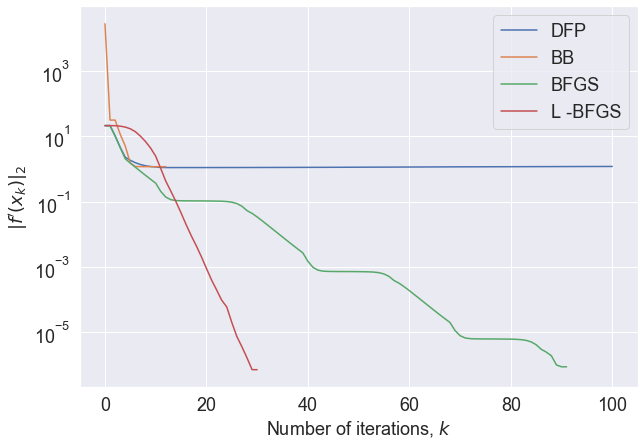

In [37]:
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 7))

# for m in method:
plt.semilogy([np.linalg.norm(gradf(x)) for x in x_array], label="DFP")
plt.semilogy([np.linalg.norm(gradf(x)) for x in xbb_array], label="BB")
plt.semilogy([np.linalg.norm(gradf(x)) for x in x_array_bfgs], label="BFGS")
plt.semilogy([np.linalg.norm(gradf(x)) for x in x_array_lbfgs], label="L -BFGS")

# plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)